In [2]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os

### 데이터 전처리

In [3]:
# generation_q = pd.read_csv(
#     "/Users/jangseohyun/Documents/workspace/symply/DER/DATA_generation.csv"
# )
# generation_q["Time"] = pd.to_datetime(generation_q["Time"], format="%Y-%m-%d %H:%M")
# generation_q["Hour"] = generation_q["Time"].dt.floor("h")
# generation_h = generation_q.groupby("Hour").sum(numeric_only=True)

# demand_q = pd.read_csv(
#     "/Users/jangseohyun/Documents/workspace/symply/DER/DATA_demand.csv"
# )
# demand_q["Time"] = pd.to_datetime(demand_q["Time"], format="%Y-%m-%d %H:%M")
# demand_q["Hour"] = demand_q["Time"].dt.floor("h")
# demand_h = demand_q.groupby("Hour").sum(numeric_only=True)

# price_q = pd.read_csv(
#     "/Users/jangseohyun/Documents/workspace/symply/DER/DATA_price.csv"
# )
# price_q["Time"] = pd.to_datetime(price_q["Time"], format="%Y-%m-%d %H:%M")

# I = list(range(len(generation_q.columns) - 11))
# T = list(generation_q['Time'].dt.hour.unique())
# S = list(range(20))
# prob = {s: 1 / len(S) for s in S}

#### Generation

In [4]:
# generation_avg = np.array(
#     [[generation_h[generation_h.index.hour == t].mean().iloc[i] for t in T] for i in I]
# )


# def generate_randomized_generation(I, T, S, generation_avg, randomness_level):
#     np.random.seed(7)
#     if randomness_level == "low":
#         noise_factors = np.random.uniform(0.8, 1.2, size=(len(I), len(T), len(S)))
#     elif randomness_level == "medium":
#         noise_factors = np.random.uniform(0.5, 1.5, size=(len(I), len(T), len(S)))
#     elif randomness_level == "high":
#         noise_factors = np.random.uniform(0.2, 1.8, size=(len(I), len(T), len(S)))
#     else:
#         raise ValueError(
#             "Invalid randomness level. Please choose 'low', 'medium', or 'high'."
#         )

#     generation_r = np.zeros((len(I), len(T), len(S)))
#     for i in range(len(I)):
#         for t in range(len(T)):
#             for s in range(len(S)):
#                 generation_r[i, t, s] = generation_avg[i, t] * noise_factors[i, t, s]

#     return generation_r

#### Demand

In [5]:
# demand_avg = np.array(
#     [[demand_h[demand_h.index.hour == t].mean().iloc[i] for t in T] for i in I]
# )


# def generate_randomized_demand(I, T, S, demand_avg, randomness_level):
#     np.random.seed(17)
#     if randomness_level == "low":
#         noise_factors = np.random.uniform(0.8, 1.2, size=(len(I), len(T), len(S)))
#     elif randomness_level == "medium":
#         noise_factors = np.random.uniform(0.5, 1.5, size=(len(I), len(T), len(S)))
#     elif randomness_level == "high":
#         noise_factors = np.random.uniform(0.2, 1.8, size=(len(I), len(T), len(S)))
#     else:
#         raise ValueError(
#             "Invalid randomness level. Please choose 'low', 'medium', or 'high'."
#         )

#     demand_r = np.zeros((len(I), len(T), len(S)))
#     for i in range(len(I)):
#         for t in range(len(T)):
#             for s in range(len(S)):
#                 demand_r[i, t, s] = demand_avg[i, t] * noise_factors[i, t, s]

#     return demand_r

#### Randomize

In [6]:
# random_key = 'high'

In [7]:
# generation_r = generate_randomized_generation(I, T, S, generation_avg, random_key)
# demand_r = generate_randomized_demand(I, T, S, demand_avg, random_key)

#### Residual = generation - demand

In [8]:
# residual = np.zeros((len(I), len(T), len(S)))
# for i in range(len(I)):
#     for t in range(len(T)):
#         for s in range(len(S)):
#             residual[i, t, s] = generation_r[i, t, s] - demand_r[i, t, s]

# R = np.zeros((len(I), len(T), len(S)))
# for i in range(len(I)):
#     for t in range(len(T)):
#         for s in range(len(S)):
#             R[i, t, s] = max(0, residual[i, t, s])

#### Price 설정

In [9]:
# price_q["Hour"] = price_q["Time"].dt.floor("h")
# price_h = price_q.groupby("Hour").mean(numeric_only=True)

# price = price_h.iloc[: len(S) * len(T)]

# P_DA = np.array(
#     [sum(price["Price"].iloc[t + s * len(T)] for s in S) / len(S) * 1.2 for t in T]
# )
# P_RT = np.array([[price["Price"].iloc[t + s * len(T)] for s in S] for t in T])
# P_PN = np.array(
#     [sum(price["Price"].iloc[t + s * len(T)] for s in S) / len(S) * 2 for t in T]
# )

### 모델 DER only

In [10]:
def load_generation_data(include_files=None, date_filter=None):
    data_dir = "/Users/jangseohyun/Documents/workspace/symply/DER/data/generation"
    all_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.csv')])

    if include_files is not None:
        for file in include_files:
            if file not in all_files:
                raise ValueError(f"파일을 찾을 수 없습니다: {file}")
        files_to_load = [f for f in all_files if f in include_files]
    else:
        files_to_load = all_files

    I = len(files_to_load)  
    T = 24 
    generation_data = np.zeros((I, T)) 

    loaded_files = []
    
    for idx, file in enumerate(files_to_load):
        file_path = os.path.join(data_dir, file)
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()

        date_col = "Date"
        hour_col = "Hour (Eastern Time, Daylight-Adjusted)"
        gen_col = "Electricity Generated"

        if any(col not in df.columns for col in [date_col, hour_col, gen_col]):
            print(f"{file}: 필요한 컬럼 없음. 스킵됨.")
            continue

        if date_filter:
            df = df[df[date_col] == date_filter]
            if df.empty:
                print(f"{file}: {date_filter} 데이터 없음. 스킵됨.")
                continue 

        df = df[df[hour_col].astype(str).str.match(r'^\d+$')]
        df["Time"] = df[hour_col].astype(int)
        df = df[df["Time"].between(0, 23)]

        for t in range(T):
            if t in df["Time"].values:
                generation_data[idx, t] = df[df["Time"] == t][gen_col].values[0]

        loaded_files.append(file)

    print(f"✅ 총 {I}개 파일을 불러왔습니다: {', '.join(loaded_files)}")

    return generation_data, I, T

def generate_randomized_generation(I, T, S, data, randomness_level):
    np.random.seed(7)

    noise_ranges = {
        "low": (0.8, 1.2),
        "medium": (0.5, 1.5),
        "high": (0.2, 1.8),
    }

    if randomness_level not in noise_ranges:
        raise ValueError("Invalid randomness level. Please choose 'low', 'medium', or 'high'.")

    low, high = noise_ranges[randomness_level]
    noise_factors = np.random.uniform(low, high, size=(I, T, S))

    generation_r = np.expand_dims(data, axis=-1) * noise_factors
    
    print(f"📊 데이터 Shape: I={I}, T={T}, S={S}")
    return generation_r

def plot_generation_data(generation_data, I):
    hours = np.arange(24)
    plt.figure(figsize=(15, 9))

    for i in range(I):
        plt.plot(hours, generation_data[i], marker='o', linestyle='-', alpha=0.7, label=f'Generator {i}')

    plt.xlabel("Hour")
    plt.ylabel("Electricity Generated (kWh)")
    plt.title("Hourly Electricity Generation for All Generators")
    plt.xticks(hours)  # 0~23 시간 설정
    plt.legend(loc="upper left", fontsize='small')

    plt.show()

def plot_randomized_generation(R, I, T, S):
    hours = np.arange(T)
    
    plt.figure(figsize=(15, 9))

    for i in range(I):
        plt.plot(hours, R[i, :, S], marker='o', linestyle='-', alpha=0.7, label=f'Generator {i}')

    plt.xlabel("Hour")
    plt.ylabel("Electricity Generated (kWh)")
    plt.title(f"Randomized Hourly Generation for Scenario {S}")
    plt.xticks(hours) 
    plt.legend(loc="upper left") 

    plt.show()
       
def plot_scenarios_for_generator(R, i):

    T = R.shape[1]
    S = R.shape[2] 
    hours = np.arange(T) 

    plt.figure(figsize=(15, 9))

    for s in range(S):
        plt.plot(hours, R[i, :, s], linestyle='-', alpha=0.6, label=f'Scenario {s+1}')

    plt.xlabel("Hour")
    plt.ylabel("Electricity Generated (kWh)")
    plt.title(f"Hourly Electricity Generation for Generator {i} Across All Scenarios")
    plt.xticks(hours)
    plt.legend(loc="upper left", fontsize='small', ncol=2)
    plt.show()

def generate_rt_scenarios(rt_da, S, randomness_level):

    rt_da["Time Stamp"] = pd.to_datetime(rt_da["Time Stamp"])
    nyc_rt = rt_da[rt_da["Name"] == "N.Y.C."].copy() 

    nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")
    hourly_avg = nyc_rt.groupby("Hour")["LBMP ($/MWHr)"].mean().reset_index()
    price_hourly = hourly_avg["LBMP ($/MWHr)"].to_numpy()
    T = len(price_hourly)

    np.random.seed(17)
    noise_ranges = {
        "low": (0.95, 1.05),
        "medium": (0.85, 1.15),
        "high": (0.7, 1.3),
    }

    if randomness_level not in noise_ranges:
        raise ValueError("Invalid randomness level. Choose from 'low', 'medium', 'high'.")

    low, high = noise_ranges[randomness_level]
    noise_factors = np.random.uniform(low, high, size=(T, S))

    P_RT = np.expand_dims(price_hourly, axis=-1) * noise_factors

    return P_RT

def plot_rt_scenarios(P_RT):
    T, S = P_RT.shape
    hours = np.arange(T)

    plt.figure(figsize=(15, 8))

    for s in range(S):
        plt.plot(hours, P_RT[:, s], linestyle='-', alpha=0.6, label=f"Scenario {s+1}")

    plt.xlabel("Hour")
    plt.ylabel("Price ($/MWHr)")
    plt.title("Real-Time Price Scenarios (Hourly Averaged)")
    plt.xticks(hours)
    plt.legend(loc="upper left", fontsize="small", ncol=2)

    plt.show()
    
only_profit = np.array(pd.read_csv("result/result_only_profit.csv"))
ny_da = pd.read_csv("/Users/jangseohyun/Documents/workspace/symply/DER/data/price/20220718da.csv")
ny_rt = pd.read_csv("/Users/jangseohyun/Documents/workspace/symply/DER/data/price/20220718rt.csv")
ny_da["Time Stamp"] = pd.to_datetime(ny_da["Time Stamp"])
ny_da["Hour"] = ny_da["Time Stamp"].dt.hour
nyc_data = ny_da[ny_da["Name"] == "N.Y.C."]
P_DA = nyc_data["LBMP ($/MWHr)"].to_numpy() * 1.3
P_PN = P_DA * 1.5

# plot_generation_data(generation_data, 10)
# plot_randomized_generation(R, I, T, 7)
# plot_scenarios_for_generator(R, 1)
# plot_rt_scenarios(P_RT)

# include_files = ['1201.csv', '137.csv', '281.csv', '397.csv', '401.csv', '430.csv', '514.csv', '524.csv', '775.csv', '89.csv']
include_files = ['1201.csv', '137.csv', '401.csv', '524.csv', '89.csv']
generation_data, I, T = load_generation_data(include_files, "2022-07-18")

S = 20
randomness_level = "medium"
R = generate_randomized_generation(I, T, S, generation_data, randomness_level)
P_RT = generate_rt_scenarios(ny_rt, S, randomness_level)


✅ 총 5개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv, 524.csv, 89.csv
📊 데이터 Shape: I=5, T=24, S=20


/var/folders/2_/9m9qjphn0xs45xzpvf1hl0j00000gn/T/ipykernel_64177/2046979868.py:126: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")


In [11]:
only = gp.Model("only")

x = only.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
y_plus = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
y_minus = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")

M = max(R[i, t, s] for i in range(I) for t in range(T) for s in range(S))
z = only.addVars(I, T, S, vtype=GRB.BINARY, name="z")

only.update()

obj = gp.quicksum(
    P_DA[t] * x[i, t] for i in range(I) for t in range(T)
) + gp.quicksum(
    1/S * (P_RT[t, s] * y_plus[i, t, s] - P_PN[t] * y_minus[i, t, s])
    for i in range(I)
    for t in range(T)
    for s in range(S)
)

only.setObjective(obj, GRB.MAXIMIZE)

Set parameter Username
Set parameter LicenseID to value 2611964
Academic license - for non-commercial use only - expires 2026-01-20


In [12]:
for i in range(I):
    for t in range(T):
        for s in range(S):
            only.addConstr(R[i, t, s] - x[i, t] == y_plus[i, t, s] - y_minus[i, t, s])

for i in range(I):
    for t in range(T):
        for s in range(S):
            only.addConstr(y_plus[i, t, s] <= R[i, t, s])

for i in range(I):
    for t in range(T):
        for s in range(S):
            only.addConstr(y_plus[i, t, s] <= M * z[i, t, s])
            only.addConstr(y_minus[i, t, s] <= M * (1 - z[i, t, s]))

only.optimize()

if only.status == GRB.OPTIMAL:
    print("Optimal solution found!")
    print(f"Objective value: {only.objVal}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 9600 rows, 7320 columns and 19200 nonzeros
Model fingerprint: 0x8bcbcf41
Variable types: 4920 continuous, 2400 integer (2400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [3e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 6e+02]
Found heuristic solution: objective 1150530.1811
Presolve removed 9540 rows and 7259 columns
Presolve time: 0.04s
Presolved: 60 rows, 61 columns, 140 nonzeros
Found heuristic solution: objective 1539265.3541
Variable types: 41 continuous, 20 integer (20 binary)

Root relaxation: interrupted, 30 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0

### 결과 분석

#### 수익 분석

In [13]:
# Day-ahead 수익 비교
total_da_profit_obj = 0
for i in range(I):
    for t in range(T):
        total_da_profit_obj += P_DA[t] * x[i,t].x

# Real-time 수익 비교
total_rt_profit_obj = 0
for i in range(I):
    for t in range(T):
        for s in range(S):
            rt_profit_obj = P_RT[t, s] * y_plus[i, t, s].x
            total_rt_profit_obj += 1/S * rt_profit_obj

# 패널티 비용 비교
total_penalty_cost_obj = 0
for i in range(I):
    for t in range(T):
        for s in range(S):
            penalty_cost_obj = P_PN[t] * y_minus[i, t, s].x
            total_penalty_cost_obj += 1/S * penalty_cost_obj

# 총 시스템 이익 (목적 함수 기반)
total_system_profit_obj = total_da_profit_obj + total_rt_profit_obj - total_penalty_cost_obj

# 결과 출력
print(f"DA: {total_da_profit_obj:.2f}")
print(f"RT: {total_rt_profit_obj:.2f}")
print(f"Penalty: {total_penalty_cost_obj:.2f}")
print(f"목적 함수 기반 총 이익 (_obj): {total_system_profit_obj:.2f}")

DA: 374392.90
RT: 1186293.00
Penalty: 21420.54
목적 함수 기반 총 이익 (_obj): 1539265.35


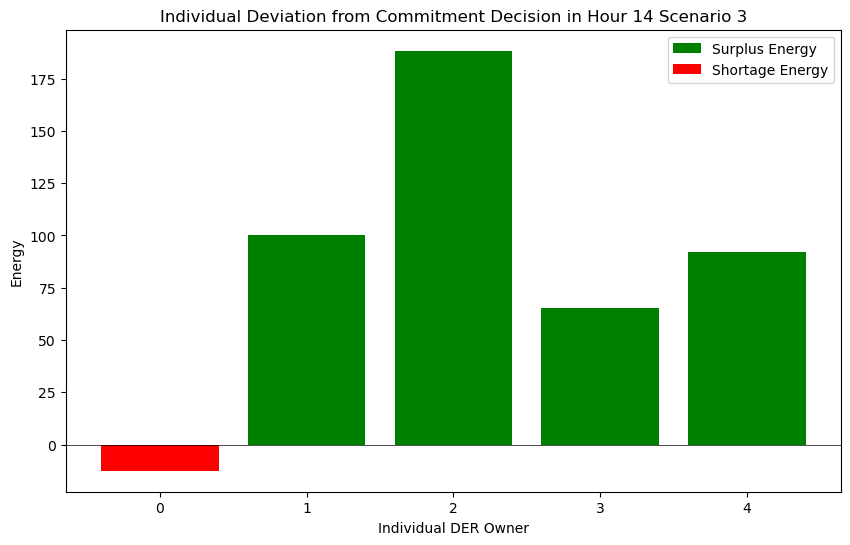

In [14]:
# ✅ 특정 시간과 시나리오 선택
t_target = 14  # 원하는 시간 (예: 13시)
s_target = 3  # 원하는 시나리오 (예: 시나리오 3)

# ✅ 개별 DER owner들의 y_plus와 y_minus 값 추출
y_plus_values = [y_plus[i, t_target, s_target].x for i in range(I)]
y_minus_values = [
    -y_minus[i, t_target, s_target].x for i in range(I)
]  # Shortage는 음수로 변환

# ✅ DER owner 인덱스
der_indices = np.arange(I)

# ✅ Figure 설정
fig, ax = plt.subplots(figsize=(10, 6))

# ✅ Surplus (y_plus) -> 초록색
ax.bar(der_indices, y_plus_values, color="green", label="Surplus Energy")

# ✅ Shortage (y_minus) -> 빨간색
ax.bar(der_indices, y_minus_values, color="red", label="Shortage Energy")

# ✅ 0 기준선 추가
ax.axhline(0, color="black", linewidth=0.5)

# ✅ 레이블 및 축 설정
ax.set_xlabel("Individual DER Owner")
ax.set_ylabel("Energy")
ax.set_xticks(der_indices)  # DER owner 인덱스 설정
ax.legend()
# ax.set_ylim(-4, 19)

# ✅ 제목 추가
plt.title(
    f"Individual Deviation from Commitment Decision in Hour {t_target} Scenario {s_target}"
)

# ✅ 그래프 출력
plt.show()

#### 하루 개인별 커밋량 합 분석

In [15]:
sum_x = 0
for t in range(T):
    time_sum = sum(x[i,t].x for i in range(I))
    print(f"시간 {t}: {time_sum}")
    sum_x += time_sum
print(f"총 하루 commitment: {sum_x:.2f}")


시간 0: 0.0
시간 1: 0.0
시간 2: 0.0
시간 3: 0.0
시간 4: 0.28403118755573914
시간 5: 0.0
시간 6: 2.4981276760799687
시간 7: 7.445725211758897
시간 8: 24.369290928759025
시간 9: 141.54069608000876
시간 10: 301.98973431531476
시간 11: 0.0
시간 12: 0.0
시간 13: 0.0
시간 14: 1032.020294451971
시간 15: 0.0
시간 16: 536.169079397722
시간 17: 0.0
시간 18: 0.0
시간 19: 331.91600206193453
시간 20: 89.37735829078197
시간 21: 17.02908218068784
시간 22: 0.0
시간 23: 0.0
총 하루 commitment: 2484.64


#### 개인 수익 분석

In [16]:
# 모든 der의 profit 합계 계산
total_der_profit = 0
der_profit = {}
for i in range(I):
    # 각 der i의 profit 합계 계산
    der_profit[i] = sum(P_DA[t] * x[i,t].x + sum(1/S * (P_RT[t,s] * y_plus[i,t,s].x - P_PN[t] * y_minus[i,t,s].x) for s in range(S)) for t in range(T))
    total_der_profit += der_profit[i]

print("\nder_profit:")
for i in range(I):
    print(f"[{i}] {der_profit[i]:.2f}")

print(f"\n모든 der의 profit 합계: {total_der_profit:.2f}")



der_profit:
[0] 204610.06
[1] 340694.55
[2] 391107.28
[3] 446291.43
[4] 156562.03

모든 der의 profit 합계: 1539265.35


### 결과 저장

In [17]:
# R_sum = {(i, t): sum(R[i, t, s] for s in S) / len(S) for i in I for t in T}
# R_df = pd.DataFrame({i: {t: R_sum[i, t] for t in T} for i in I})
# R_df.to_csv('result_R.csv', index=False)

# pd.DataFrame(list(P_DA.items()), columns=['time', 'price']).to_csv('result_P_DA.csv', index=False)

total_x_only = {t: sum(x[i,t].x for i in range(I)) for t in range(T)}
total_x_only_df = pd.DataFrame({'total_x_only': total_x_only})
total_x_only_df.to_csv('result/result_base_totalX.csv', index=False)

only_profit_value = pd.DataFrame({'only_profit_value': der_profit})
only_profit_value.to_csv('result/result_only_profit.csv', index=False)

only_obj = pd.DataFrame({'only_obj': [only.objVal]})
only_obj.to_csv('result/result_only_obj.csv', index=False)
